# Ublind
An amazing python script for blind people to interpret Umaps.

In [2]:
import os
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
from midiutil import MIDIFile
from scipy.io.wavfile import write
import pretty_midi

In [3]:
adata = sc.read("cellxgene_unannotated.h5ad")
adata

/Users/zachleon/anaconda3/envs/Spatial_analysis/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 237913 × 71
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'core_cluster', 'cluster_name', 'n_counts', 'n_genes', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    la

In [26]:
#doesn't include the X_coordinates 
def umap_to_pretty_midi(adata, midi_output_path="umap_music_pretty_midi.mid", total_duration=10):
    # Ensure UMAP coordinates are present
    if 'X_umap' not in adata.obsm_keys():
        raise ValueError("UMAP coordinates not found in the provided AnnData object.")
    
    # Extract UMAP coordinates
    umap_coords = adata.obsm['X_umap']
    y_min, y_max = np.min(umap_coords[:, 1]), np.max(umap_coords[:, 1])
    
    # MIDI note range for a standard 88-key piano
    lowest_note = 21
    highest_note = 108
    
    # Create a PrettyMIDI object
    midi_data = pretty_midi.PrettyMIDI()
    # Create an Instrument instance for a piano
    piano_program = pretty_midi.instrument_name_to_program('Cello')
    piano = pretty_midi.Instrument(program=piano_program)
    
    # Calculate the start time and duration for each note
    num_points = len(umap_coords)
    note_duration = total_duration / num_points  # Evenly distribute notes over total_duration
    
    for i, (_, y) in enumerate(umap_coords):
        # Map y-coordinate to MIDI note range
        midi_note = int(np.round(np.interp(y, [y_min, y_max], [lowest_note, highest_note])))
        start_time = i * note_duration
        end_time = start_time + note_duration
        
        # Create a Note instance for each UMAP point
        note = pretty_midi.Note(
            velocity=100, pitch=midi_note, start=start_time, end=end_time)
        # Add it to the piano instrument
        piano.notes.append(note)
    
    # Add the piano instrument to the PrettyMIDI object
    midi_data.instruments.append(piano)
    
    # Write out the MIDI data to a file
    midi_data.write(midi_output_path)
    
    print(f"MIDI file saved to {midi_output_path}")

In [55]:
#actually maps it properly.
def umap_to_pretty_midi(adata, midi_output_path="umap_music_pretty_midi.mid", total_duration=10):
    # Ensure UMAP coordinates are present
    if 'X_umap' not in adata.obsm_keys():
        raise ValueError("UMAP coordinates not found in the provided AnnData object.")
    
    # Extract UMAP coordinates
    umap_coords = adata.obsm['X_umap']
    x_min, x_max = np.min(umap_coords[:, 0]), np.max(umap_coords[:, 0])
    y_min, y_max = np.min(umap_coords[:, 1]), np.max(umap_coords[:, 1])
    
    # MIDI note range for a standard 88-key piano
    lowest_note = 21
    highest_note = 108
    
    # Create a PrettyMIDI object
    midi_data = pretty_midi.PrettyMIDI()
    # Create an Instrument instance for a piano
    piano_program = pretty_midi.instrument_name_to_program('Acoustic Grand Piano')
    piano = pretty_midi.Instrument(program=piano_program)
    
    # Assuming a uniform note duration for simplicity, adjust as needed
    note_duration = 0.5  # Fixed note duration, feel free to adjust
    
    for x, y in umap_coords:
        # Map x-coordinate to start time within the total duration
        start_time = np.interp(x, [x_min, x_max], [0, total_duration - note_duration])
        
        # Map y-coordinate to MIDI note range
        midi_note = int(np.round(np.interp(y, [y_min, y_max], [lowest_note, highest_note])))
        
        # Create a Note instance for this point
        note = pretty_midi.Note(
            velocity=100, pitch=midi_note, start=start_time, end=start_time + note_duration)
        # Add it to the piano instrument
        piano.notes.append(note)
    
    # Add the piano instrument to the PrettyMIDI object
    midi_data.instruments.append(piano)
    
    # Write out the MIDI data to a file
    midi_data.write(midi_output_path)
    
    print(f"MIDI file saved to {midi_output_path}")

/Users/zachleon/anaconda3/envs/Spatial_analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


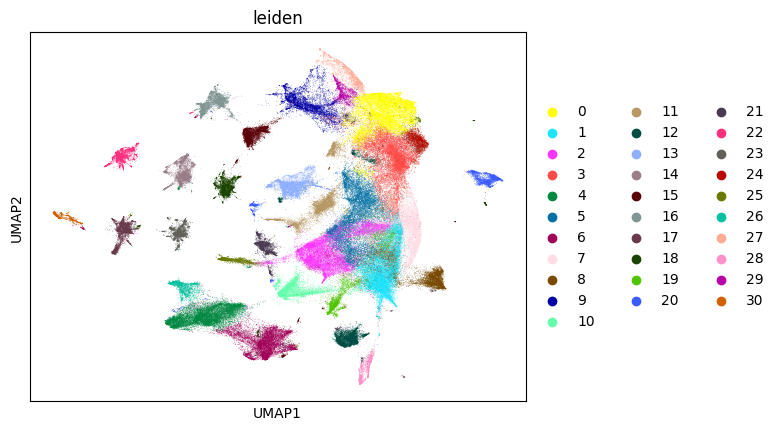

In [13]:
sc.pl.umap(adata,color=['leiden'],wspace=0.4,)

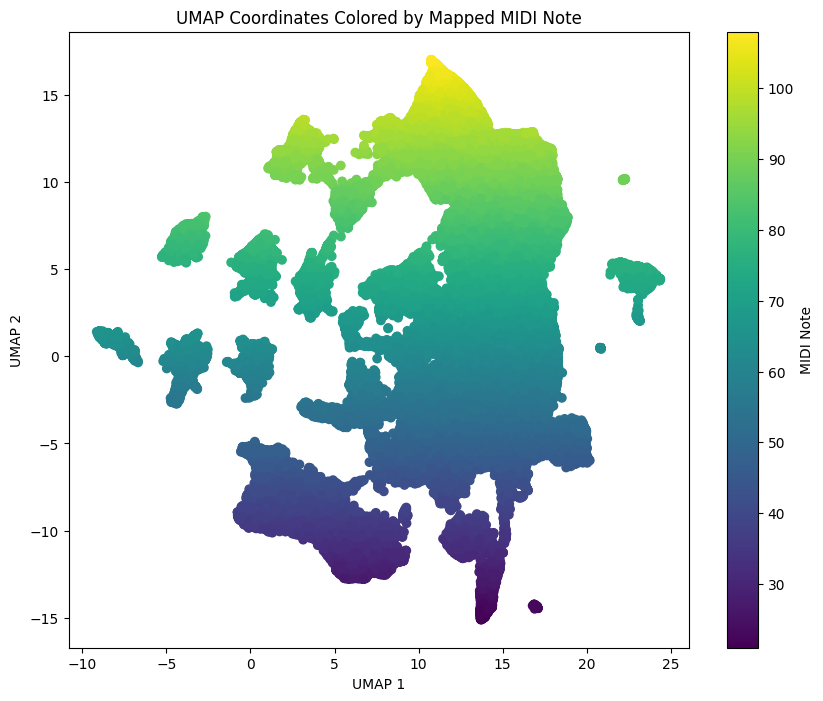

In [43]:
# MIDI note range for a standard 88-key piano
lowest_note = 21
highest_note = 108
def umap_to_pretty_midi_and_return_notes(adata, midi_output_path="umap_music_pretty_midi.mid", total_duration=120):
    # Ensure UMAP coordinates are present
    if 'X_umap' not in adata.obsm_keys():
        raise ValueError("UMAP coordinates not found in the provided AnnData object.")
    
    # Extract UMAP coordinates
    umap_coords = adata.obsm['X_umap']
    y_min, y_max = np.min(umap_coords[:, 1]), np.max(umap_coords[:, 1])
    
    # MIDI note mappings
    midi_notes = []
    
    for i, (_, y) in enumerate(umap_coords):
        # Map y-coordinate to MIDI note range
        midi_note = int(np.round(np.interp(y, [y_min, y_max], [lowest_note, highest_note])))
        midi_notes.append(midi_note)
    
    # Proceed to generate MIDI file as before
    # (Skipping for brevity, but you'd include the pretty_midi code here)
    
    return umap_coords, midi_notes

umap_coords, midi_notes = umap_to_pretty_midi_and_return_notes(adata, "umap_music_pretty_midi.mid", 120)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=midi_notes, cmap='viridis')
plt.colorbar(scatter, label='MIDI Note')
plt.title('UMAP Coordinates Colored by Mapped MIDI Note')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [56]:
umap_to_pretty_midi(adata, midi_output_path="umap_music_pretty_midi_short.mid")

MIDI file saved to umap_music_pretty_midi_short_cello.mid
